In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import javalang
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from collections import Counter
from itertools import chain

import tensorflow as tf
# import tensorflow_addons as tfa # TODO: find ready to use seq2seq modules here
from tensorflow.keras import layers
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

tqdm.pandas()

/home/tony/source/programming-tools/.venv/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [55]:
import sys
print(f'PYTHONPATH before: {sys.path}')
sys.path.append('../..')
print(f'PYTHONPATH after: {sys.path}')

PYTHONPATH before: ['/home/tony/source/programming-tools/lib/notebooks', '/home/tony/source/programming-tools/.venv/lib/python37.zip', '/home/tony/source/programming-tools/.venv/lib/python3.7', '/home/tony/source/programming-tools/.venv/lib/python3.7/lib-dynload', '/usr/lib/python3.7', '', '/home/tony/source/programming-tools/.venv/lib/python3.7/site-packages', '/home/tony/source/programming-tools/.venv/lib/python3.7/site-packages/IPython/extensions', '/home/tony/.ipython']
PYTHONPATH after: ['/home/tony/source/programming-tools/lib/notebooks', '/home/tony/source/programming-tools/.venv/lib/python37.zip', '/home/tony/source/programming-tools/.venv/lib/python3.7', '/home/tony/source/programming-tools/.venv/lib/python3.7/lib-dynload', '/usr/lib/python3.7', '', '/home/tony/source/programming-tools/.venv/lib/python3.7/site-packages', '/home/tony/source/programming-tools/.venv/lib/python3.7/site-packages/IPython/extensions', '/home/tony/.ipython', '../..']


In [57]:
from src.preprocessing.tokens import get_subtokens

get_subtokens('transformSearchResponse')

['transform', 'search', 'response']

- [ ] Add a start and end token to each sentence.
- [ ] Create a token index and reverse token index (dictionaries mapping from token → id and id → token).
- [ ] Pad each sequence to a maximum length.

In [2]:
data_path = '../../data/method-names-rich/elasticsearch.csv'

In [3]:
# TODO: we take only a few samples just to run a single training loop
# TODO: Think data processing through: put data preprocessing in a separate notebook
#      which takes in raw CSV data and spits out tensors?
df = pd.read_csv(data_path).dropna().head(1000)
df.head()

,file_name,class_name,method_name,return_type,arguments,body,documentation,modifiers,annotations
0,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testInvalidBlockQuote,void,[],"{ String input = ""\""foo\"": \""\""\""bar\""""; expec...",None,['public'],[]
1,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testSimpleBlockQuote,void,[],"{ assertEquals(""\""foo\"": \""bort baz\"""", replac...",None,['public'],[]
2,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testMultipleBlockQuotes,void,[],"{ assertEquals( ""\""foo\"": \""bort baz\"", \""bar\...",None,['public'],[]
3,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testEscapingInBlockQuote,void,[],"{ assertEquals(""\""foo\"": \""bort\\\"" baz\"""", re...",None,['public'],[]
4,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testIsDocWriteRequest,void,[],{ assertTrue((boolean) RestTestsFromSnippetsTa...,None,['public'],[]


In [4]:
def split_camel_case(str):
    words = [[str[0]]]
  
    for c in str[1:]: 
        if words[-1][-1].islower() and c.isupper(): 
            words.append(list(c)) 
        else: 
            words[-1].append(c) 
  
    return [''.join(word).lower() for word in words]

print(split_camel_case('transformSearchResponse'))
print(split_camel_case('modifySearchResponseData'))

['transform', 'search', 'response']
['modify', 'search', 'response', 'data']


In [5]:
# TODO: use a smarter identifier splitter
def get_subtokens(token):
    return split_camel_case(token)

def compute_loss(target_token, predicted_token):
    target_subtokens = get_subtokens(target_token) # a.k.a required subtokens
    predicted_subtokens = get_subtokens(predicted_token)
    overlapping = Counter(target_subtokens) & Counter(predicted_subtokens)
    overlapping_count = sum(overlapping.values())
    
    precision = 1.0 * overlapping_count / len(predicted_subtokens)
    recall = 1.0 * overlapping_count / len(target_subtokens)
    f1 = (2.0 * precision * recall) / (precision + recall)
    
    return { 'precision': precision, 'recall': recall, 'f1': f1 }

compute_loss('transformSearchResponse', 'modifySearchResponseData')

{'precision': 0.5, 'recall': 0.6666666666666666, 'f1': 0.5714285714285715}

In [6]:
# define input vocabulary

# TODO: investigate why source code body is not tokenized by javalang
invalid_body_count = 0

def tokenize_method_body(code):
    global invalid_body_count
    
    try:
        return list(map(lambda token: token.value, javalang.tokenizer.tokenize(code)))
    except Exception as e:
        invalid_body_count += 1
        if invalid_body_count % 1000 == 0:
            print(f'invalid_body_count = {invalid_body_count}')
        return []

repeating_body_tokens = pd.Series(chain.from_iterable(
    df.body \
        .progress_apply(tokenize_method_body) \
        .values
))
repeating_body_tokens

0                             {
1                        String
2                         input
3                             =
4        "\"foo\": \"\"\"bar\""
                  ...          
39715                         )
39716                         )
39717                         )
39718                         ;
39719                         }
Length: 39720, dtype: object

In [7]:
unique_body_tokens = pd.DataFrame.from_dict(Counter(repeating_body_tokens.values), orient='index') \
    .sort_values(by=0, ascending=False) \
    .reset_index().rename(columns={'index': 'token', 0: 'count'})

unique_body_tokens.head(30)

,token,count
0,),5043
1,(,5030
2,.,3491
3,;,2670
4,",",2037
5,{,1441
6,},1415
7,=,726
8,+,506
9,return,471


In [8]:
len(unique_body_tokens[unique_body_tokens['count'] >= 2])

1618

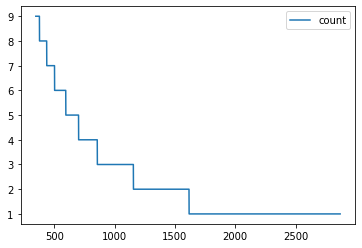

In [9]:
unique_body_tokens[unique_body_tokens['count'] < 10].plot()

In [10]:
unique_body_tokens[unique_body_tokens['count'] == 1].sample(10)

,token,count
2058,CharSequence,1
2152,"""--scan""",1
1641,"""Found invalid patterns:\n""",1
2711,restart,1
2661,"""Got successful response [{}] from URL [{}]""",1
1689,"""-Xmx1g""",1
2406,"""src/main/java/Foo.java""",1
2640,getExecuted,1
2811,copyTo,1
1688,getForbiddenAPIsConfiguration,1


[Text(0, 0.5, 'Subtoken frequency'),
 Text(0.5, 0, 'Rank by frequency count'),
 Text(0.5, 1.0, 'Distribution of subtoken frequency')]

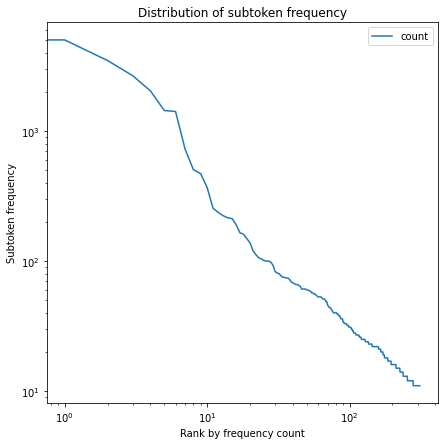

In [11]:
# index by position in the list which is sorted by frequency
ax = unique_body_tokens[unique_body_tokens['count'] > 10] \
    .plot(loglog=True, figsize=(7, 7))
ax.set(title='Distribution of subtoken frequency', xlabel='Rank by frequency count', ylabel='Subtoken frequency')

In [12]:
# # yes, the pandas groupby interface is THIS stupid :) ...
# unique_body_tokens = repeating_body_tokens \
#     .groupby(lambda index: repeating_body_tokens[index]).count()

# unique_body_tokens.head(30)

In [13]:
# define output vocabulary

repeating_method_subtokens = pd.Series(chain.from_iterable(df.method_name.progress_apply(get_subtokens).values))

# yes, the pandas groupby interface is THIS stupid :) ...
unique_method_subtokens = repeating_method_subtokens \
    .groupby(lambda index: repeating_method_subtokens[index]).count() \
    .sort_values(ascending=False)

unique_method_subtokens.head(30)

get           215
test          190
set            96
check          62
version        62
file           52
task           46
assert         40
create         39
dir            35
project        35
java           32
with           31
name           30
of             28
is             28
to             27
exception      26
build          25
jdk            22
dependency     19
should         19
path           18
run            18
then           18
on             17
home           17
for            16
configure      16
not            16
dtype: int64

[Text(0, 0.5, 'Subtoken frequency'),
 Text(0.5, 0, 'Rank by frequency count'),
 Text(0.5, 1.0, 'Distribution of subtoken frequency')]

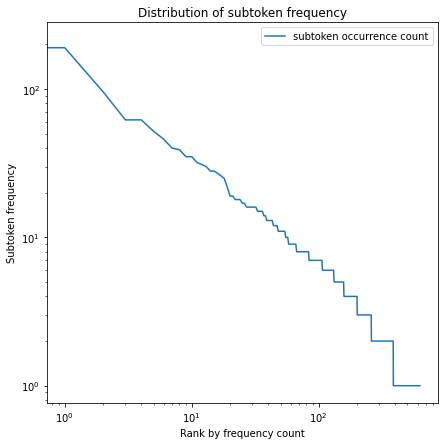

In [14]:
# index by position in the list which is sorted by frequency
ax = unique_method_subtokens \
    .sort_values(ascending=False).reset_index().rename(columns={0: 'subtoken occurrence count'}) \
    .plot(loglog=True, figsize=(7, 7))
ax.set(title='Distribution of subtoken frequency', xlabel='Rank by frequency count', ylabel='Subtoken frequency')

In [15]:
len(unique_method_subtokens)

627

In [16]:
df_unique_method_name_subtokens = pd.DataFrame.from_dict(Counter(repeating_method_subtokens.values), orient='index') \
    .sort_values(by=0, ascending=False) \
    .reset_index().rename(columns={'index': 'token', 0: 'count'})

df_unique_method_name_subtokens.head(30)

,token,count
0,get,215
1,test,190
2,set,96
3,check,62
4,version,62
5,file,52
6,task,46
7,assert,40
8,create,39
9,dir,35


In [17]:
df_unique_method_name_subtokens[df_unique_method_name_subtokens['count'] == 1].sample(10)

,token,count
498,specification,1
471,past,1
563,locate,1
419,exclusions,1
568,pid,1
586,retain,1
411,mock,1
470,defers,1
430,builder,1
577,certificate,1


In [18]:
# dataset

df['body_tokens'] = df['body'].progress_apply(tokenize_method_body)

# the output sequences are marked with a <start> and <end> special tokens
df['method_name_subtokens'] = df['method_name'].progress_apply(get_subtokens)
df_clean = df[df.body_tokens.str.len() > 0] # remove invalid methods which cannot be parsed

df.head(5)

,file_name,class_name,method_name,return_type,arguments,body,documentation,modifiers,annotations,body_tokens,method_name_subtokens
0,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testInvalidBlockQuote,void,[],"{ String input = ""\""foo\"": \""\""\""bar\""""; expec...",None,['public'],[],"[{, String, input, =, ""\""foo\"": \""\""\""bar\"""", ...","[test, invalid, block, quote]"
1,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testSimpleBlockQuote,void,[],"{ assertEquals(""\""foo\"": \""bort baz\"""", replac...",None,['public'],[],"[{, assertEquals, (, ""\""foo\"": \""bort baz\"""", ...","[test, simple, block, quote]"
2,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testMultipleBlockQuotes,void,[],"{ assertEquals( ""\""foo\"": \""bort baz\"", \""bar\...",None,['public'],[],"[{, assertEquals, (, ""\""foo\"": \""bort baz\"", \...","[test, multiple, block, quotes]"
3,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testEscapingInBlockQuote,void,[],"{ assertEquals(""\""foo\"": \""bort\\\"" baz\"""", re...",None,['public'],[],"[{, assertEquals, (, ""\""foo\"": \""bort\\\"" baz\...","[test, escaping, in, block, quote]"
4,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testIsDocWriteRequest,void,[],{ assertTrue((boolean) RestTestsFromSnippetsTa...,None,['public'],[],"[{, assertTrue, (, (, boolean, ), RestTestsFro...","[test, is, doc, write, request]"



% of method_names being reduced: 0.0375854214123007


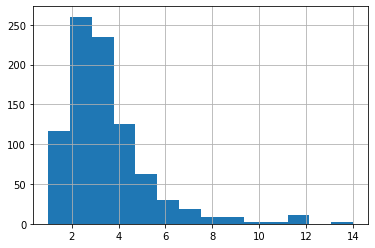

In [19]:
method_name_lengths = df_clean.method_name_subtokens.progress_apply(len)

method_name_lengths.hist(bins=method_name_lengths.max())

# we will add the <start> and <end> tokens which will effectively increase the seq length to 10 during training and prediction
max_decoder_seq_length = 8
number_of_method_names_below_threshold = len(np.where(method_name_lengths.values < max_decoder_seq_length)[0])
print(f"% of method_names being reduced: {1 - number_of_method_names_below_threshold / len(method_name_lengths)}")

In [20]:
# also cut the first max_decoder_seq_length (i.e. 8) subtokens, in order to have a fixed length
method_name_subtokens_with_start_and_end = df_clean['method_name_subtokens'] \
    .progress_apply(lambda tokens: ['<start>'] + tokens[:max_decoder_seq_length] + ['<end>'])

method_name_subtokens_with_start_and_end.progress_apply(len).describe()

count    878.000000
mean       5.095672
std        1.678886
min        3.000000
25%        4.000000
50%        5.000000
75%        6.000000
max       10.000000
Name: method_name_subtokens, dtype: float64

In [21]:
def get_vocabulary(series):
    all_repeating = pd.Series(chain.from_iterable(series.values))

    return pd.DataFrame.from_dict(Counter(all_repeating.values), orient='index') \
        .sort_values(by=0, ascending=False) \
        .reset_index().rename(columns={'index': 'token', 0: 'count'})

In [22]:
input_vocabulary = get_vocabulary(df_clean.body_tokens)
output_vocabulary = get_vocabulary(method_name_subtokens_with_start_and_end)
len(input_vocabulary), len(output_vocabulary)

(2870, 579)

In [23]:
# TODO: compute what percentage of the input tokens (including repetition) will be ignored
min_input_token_count = 10
reduced_input_vocabulary = pd.Series(['<UNK>']).append(
    input_vocabulary[input_vocabulary['count'] >= min_input_token_count]['token']
)

In [24]:
ignored_input_tokens_percentage = input_vocabulary[input_vocabulary['count'] < min_input_token_count]['count'].sum() / input_vocabulary[input_vocabulary['count'] >= min_input_token_count]['count'].sum()
print(f'reduced input vocabulary size: {len(reduced_input_vocabulary)}')
print(f'percentage of ignore input: {ignored_input_tokens_percentage}')

reduced input vocabulary size: 349
percentage of ignore input: 0.17769146381237585


In [25]:
input_token_to_id = { token:id for id, token in enumerate(reduced_input_vocabulary) }
id_to_input_token = reduced_input_vocabulary

In [26]:
len(input_token_to_id), len(id_to_input_token)

(349, 349)

In [27]:
output_token_to_id = { token:id for id, token in enumerate(output_vocabulary.token) }
id_to_output_token = output_vocabulary.token

In [28]:
[(key, value) for key, value in output_token_to_id.items()][:10]

[('<start>', 0),
 ('<end>', 1),
 ('get', 2),
 ('test', 3),
 ('set', 4),
 ('check', 5),
 ('version', 6),
 ('file', 7),
 ('task', 8),
 ('assert', 9)]

In [29]:
def input_tokens_to_ids(body_tokens):
    return [input_token_to_id[token] if token in input_token_to_id else 0 for token in body_tokens]

In [30]:
def output_tokens_to_ids(output_tokens):
    return [output_token_to_id[token] if token in output_token_to_id else 0 for token in output_tokens]

In [31]:
# raw hyper parameters

max_input_length = 100
max_output_length = method_name_subtokens_with_start_and_end.apply(len).max() # 10

# TODO: limit the input vocabulary size for now
input_vocab_size = 10000 # the number of method body tokens
input_embedding_dim = 50

output_vocab_size = len(output_vocabulary) # used for the softmax layer, like num_classes
output_embedding_dim = 50

latent_dim = 128 # encoder-decoder latent space dimensions

epochs = 10
batch_size=64

In [32]:
method_name_subtoken_ids = method_name_subtokens_with_start_and_end \
    .progress_apply(output_tokens_to_ids)
#     .progress_apply(lambda l: l[-max_output_length:])

method_name_subtoken_ids.progress_apply(len).describe()

count    878.000000
mean       5.095672
std        1.678886
min        3.000000
25%        4.000000
50%        5.000000
75%        6.000000
max       10.000000
Name: method_name_subtokens, dtype: float64

In [33]:
method_name_subtokens_with_start_and_end[0], method_name_subtoken_ids[0]

(['<start>', 'test', 'invalid', 'block', 'quote', '<end>'],
 [0, 3, 69, 156, 207, 1])

In [34]:
# decoder_inputs
decoder_inputs = method_name_subtoken_ids.progress_apply(lambda seq: seq[:-1])
decoder_inputs

0                         [0, 3, 69, 156, 207]
1                        [0, 3, 413, 156, 207]
2                        [0, 3, 411, 156, 403]
3                    [0, 3, 402, 29, 156, 207]
4                     [0, 3, 17, 401, 64, 399]
                        ...                   
992                           [0, 3, 315, 165]
995                   [0, 3, 84, 108, 26, 108]
996                  [0, 3, 84, 108, 418, 108]
997    [0, 3, 84, 108, 419, 63, 420, 421, 272]
999                       [0, 3, 578, 111, 66]
Name: method_name_subtokens, Length: 878, dtype: object

In [35]:
# TODO:
# 1. limit output sequences to a max length
# 2. add <start> and <end> special tokens
# 3. pad the sequencecs
# 4. one hot encode the labels
padded_output_sequences = pad_sequences(
    method_name_subtoken_ids,
    maxlen=max_output_length,
    dtype='int32',
    padding='post',
    truncating='post',
    value=-1 # TODO: 0 is test and not <UNK>
)

padded_output_sequences.shape

(878, 10)

In [36]:
len(padded_output_sequences)

878

In [37]:
# decoder_outputs = np.zeros(
#     (len(padded_output_sequences), max_output_length, output_vocab_size),
#     dtype='float32'
# )

indices = []
for seq_id, seq in enumerate(padded_output_sequences):
    for token_index, token_id in enumerate(seq):
        if token_id >= 0: # ignore the -1 padding value in the output sequences
            indices.append([seq_id, token_index, token_id])

tensor_decoder_outputs = tf.SparseTensor(
    indices=indices,
    values=np.ones(len(indices)),
    dense_shape=[len(padded_output_sequences), max_output_length, output_vocab_size]
)
        
tensor_decoder_outputs.shape

TensorShape([878, 10, 579])

In [38]:
body_token_ids = df_clean.body_tokens.progress_apply(input_tokens_to_ids).progress_apply(lambda l: l[-max_input_length:])
body_token_ids.progress_apply(len).describe()

count    878.000000
mean      35.274487
std       31.199488
min        2.000000
25%       10.000000
50%       22.500000
75%       53.000000
max      100.000000
Name: body_tokens, dtype: float64

In [39]:
padded_input_sequences = pad_sequences(
    body_token_ids,
    maxlen=max_input_length,
    dtype='int32',
    padding='pre',
    truncating='pre',
    value=0 # TODO: 0 should be <UNK>
)
padded_input_sequences

array([[0, 0, 0, ..., 1, 4, 7],
       [0, 0, 0, ..., 1, 4, 7],
       [0, 0, 0, ..., 1, 4, 7],
       ...,
       [0, 0, 0, ..., 1, 4, 7],
       [0, 0, 0, ..., 1, 4, 7],
       [0, 0, 0, ..., 1, 4, 7]], dtype=int32)

In [40]:
# X_train, X_test, decoder_inputs_train, decoder_inputs_test, decoder_outputs_train, decoder_outputs_test = train_test_split(
#     padded_input_sequences,
#     decoder_inputs,
#     decoder_outputs,
#     test_size=0.2,
#     random_state=42
# )

# X_train.shape, X_test.shape, decoder_inputs_train.shape, decoder_inputs_test.shape, decoder_outputs_train.shape, decoder_outputs_test.shape

In [41]:
df_body_length = pd.DataFrame.from_dict(Counter(df_clean.body_tokens.apply(len)), orient='index') \
    .reset_index().rename(columns={'index': 'length', 0: 'count'}) \
    .sort_values(by=['length']).set_index('length')

df_body_length.head(5)

,count
length,
2,8
5,87
7,3
8,73
9,44


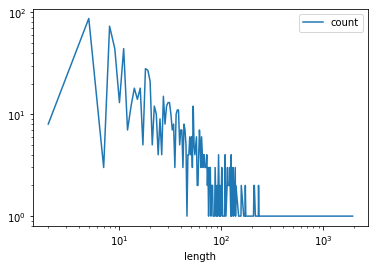

In [42]:
df_body_length.plot(loglog=True)

In [43]:
print(f'number of methods with body token count less than 100: {df_body_length[df_body_length.index < 100]["count"].sum()}')

number of methods with body token count less than 100: 782


In [44]:
df_clean.body_tokens.apply(len).describe()

count     878.000000
mean       45.239180
std        87.525711
min         2.000000
25%        10.000000
50%        22.500000
75%        53.000000
max      1945.000000
Name: body_tokens, dtype: float64

In [45]:
df_clean.method_name_subtokens.apply(len).describe()

count    878.000000
mean       3.179954
std        1.990160
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       14.000000
Name: method_name_subtokens, dtype: float64

In [46]:
# define model: input embedding > LSTM encoder > LSTM decoder > softmax

In [47]:
# TODO: use hyper parameters
# HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

In [48]:
from abc import ABC, abstractmethod

class BaseModel(ABC):
    @abstractmethod
    def fit(self, train_x, train_y): pass

    @abstractmethod
    def predict(self, test_x): pass

    @abstractmethod
    def predict_proba(self, test_x): pass

    def get_params(self, deep = True):
        return {}

    def get_grid_params(self):
        return {}

In [49]:
class Seq2Seq(BaseModel):
    def __init__(self, params):
        self.params = params

        
    def _define_model(self):
        encoder_input = layers.Input(shape=(None, ), name='encoder_input')
        encoder_embeddeding = layers.Embedding(
            input_dim=input_vocab_size,
            output_dim=input_embedding_dim,
            name='encoder_embedding'
        )(encoder_input)

        # Return states in addition to output
        _encoder_output, state_h, state_c = layers.LSTM(
            latent_dim,
            return_state=True,
            name='encoder_lstm'
        )(encoder_embeddeding)

        encoder_states = [state_h, state_c]

        decoder_input = layers.Input(shape=(None, ), name='decoder_input')
        decoder_embeddeding = layers.Embedding(
            input_dim=output_vocab_size,
            output_dim=output_embedding_dim,
            name='decoder_embeddeding'
        )(decoder_input)

        # Pass the 2 states to a new LSTM layer, as initial state
        decoder_outputs, _, _ = layers.LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            name='decoder_lstm'
        )(decoder_embeddeding, initial_state=encoder_states)

        output = layers.Dense(
            output_vocab_size,
            activation='softmax',
            name='softmax'
        )(decoder_outputs)

        model = tf.keras.Model([encoder_input, decoder_input], output)
        return model


    # train_x is a dataframe with columns head.word, tail.word, sentence
    def fit(self, train_x, train_y):
        self.train_features = self.transform(train_x)
        self.train_labels = self.transform_labels(train_y)

        self.model = LogisticRegression(**self.params['logreg_clf_params'])

        print('Fitting model...')
        self.model.fit(self.train_features, self.train_labels)


    def predict(self, test_x):
        features = self.transform(test_x)

        predictions = self.model.predict(features)

        return self.label_encoder.inverse_transform(predictions)


    # transforms the input train_x or test_x examples into features for the model
    # df is a dataframe with columns head.word, tail.word, sentence
    def transform(self, df):
        print('Tokenizing sentences...')
        df_tokenized = df['sentence'].apply(self.preprocess)
        print(df_tokenized.head())

        print('Averaging word embeddings...')
        df_vectors = df_tokenized.apply(self.average)
        print(df_vectors.head())

        vectors = np.asarray(flatten(df_vectors)).reshape(-1, self.word_embeddings_dim)
        print('Shape of transformed input: {}'.format(vectors.shape))

        return vectors


    def transform_labels(self, df):
        print('Fitting label encoder...')
        self.label_encoder.fit(df)
        print(self.label_encoder.classes_)

        print('Transforming labels...')
        labels = self.label_encoder.transform(df)
        print('Shape of transformed labels: {}'.format(labels.shape))

        return labels


    def preprocess(self, text):
        # tokenize
        word_tokens = self.tokenizer.tokenize(text)

        # clean stop words and lower cases
        return [
            word.lower()
            for word in word_tokens
            if not word in self.stop_words
        ]


    @staticmethod
    def load_word_embeddings(path):
        with open(path) as f:
            word_vec = json.load(f)

        word_embeddings = {
            obj['word']: np.asarray(obj['vec'])
            for obj in word_vec
        }
        return word_embeddings


    @staticmethod
    def average_embeddings(word_embeddings, word_embeddings_dim, words):
        embeddings = [
            word_embeddings[word]
            for word in words
            if word in word_embeddings
        ]

        if len(embeddings) > 0:
            return np.average(embeddings, axis=0)
        else:
            return np.zeros(word_embeddings_dim)

    def get_grid_params(self):
        return {
            'max_iter': (5, 100),
            'solver': ('liblinear', 'sag'),
        }


In [50]:
def build_models():
    # first define the training model
    encoder_inputs = layers.Input(shape=(None, ), name='encoder_inputs')
    encoder_embeddeding = layers.Embedding(
        input_dim=input_vocab_size,
        output_dim=input_embedding_dim,
        name='encoder_embedding'
    )(encoder_inputs)

    # Return states in addition to output
    _encoder_output, state_h, state_c = layers.LSTM(
        latent_dim,
        return_state=True,
        name='encoder_lstm'
    )(encoder_embeddeding)

    encoder_states = [state_h, state_c]

    decoder_inputs = layers.Input(shape=(None, ), name='decoder_inputs')
    decoder_embeddeding = layers.Embedding(
        input_dim=output_vocab_size,
        output_dim=output_embedding_dim,
        name='decoder_embeddeding'
    )(decoder_inputs)

    decoder_lstm = layers.LSTM(
        latent_dim,
        return_sequences=True,
        return_state=True,
        name='decoder_lstm'
    )
    # Pass the 2 states to a new LSTM layer, as initial state
    decoder_outputs, _, _ = decoder_lstm(decoder_embeddeding, initial_state=encoder_states)

    print(decoder_embeddeding.shape, state_h.shape, state_c.shape)
    
    decoder_dense = layers.Dense(
        output_vocab_size,
        activation='softmax',
        name='softmax'
    )
    output = decoder_dense(decoder_outputs)

    training_model = tf.keras.Model([encoder_inputs, decoder_inputs], output)

    # ---------------------------------------------------------
    # now, define the inference model, based on the training model
    inference_encoder_model = tf.keras.Model(encoder_inputs, encoder_states)
    # define inference decoder inputs
    inference_decoder_state_input_h = layers.Input(shape=(latent_dim,))
    inference_decoder_state_input_c = layers.Input(shape=(latent_dim,))
    inference_decoder_states_inputs = [inference_decoder_state_input_h, inference_decoder_state_input_c]

    print(decoder_inputs.shape, inference_decoder_state_input_h.shape, inference_decoder_state_input_c.shape)

    # TODO: decoder_lstm errors our with ValueError: Shape (None, None) must have rank at least 3
    # because we need to use embeddings as decoder_inputs below
    
    inference_decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_inputs, # taken from the training model's definition
        initial_state=inference_decoder_states_inputs
    )
    inference_decoder_states = [state_h, state_c]
    # apply softmax dense layer
    inference_decoder_outputs = decoder_dense(decoder_outputs)

    inference_decoder_model = Model(
        [inference_decoder_inputs] + inference_decoder_states_inputs,
        [inference_decoder_outputs] + inference_decoder_states
    )

    # return all models
    models = [training_model, inference_encoder_model, inference_decoder_model]
    return models

In [51]:
training_model, inference_encoder_model, inference_decoder_model = build_models()

training_model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

training_model.summary()

(None, None, 50) (None, 128) (None, 128)
(None, None) (None, 128) (None, 128)


ValueError: Shape (None, None) must have rank at least 3

In [ ]:
padded_decoder_inputs = pad_sequences(
    decoder_inputs,
    maxlen=max_output_length,
    dtype='int32',
    padding='post',
    truncating='post',
    value=1 # TODO: 0 should be <UNK>
)
padded_decoder_inputs

In [ ]:
padded_decoder_inputs.shape

In [ ]:
tensor_encoder_inputs = tf.convert_to_tensor(padded_input_sequences)

In [ ]:
tensor_decoder_inputs = tf.convert_to_tensor(padded_decoder_inputs)

In [ ]:
# tensor_decoder_outputs = tf.convert_to_tensor(decoder_outputs)

In [ ]:
tensor_encoder_inputs.shape, tensor_decoder_inputs.shape, tensor_decoder_outputs.shape

In [ ]:
# TODO: WTF https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
# see https://www.tensorflow.org/guide/effective_tf2#use_tfconfigexperimental_run_functions_eagerly_when_debugging
tf.config.experimental_run_functions_eagerly(True)

In [ ]:
history = model.fit(
    [tensor_encoder_inputs, tensor_decoder_inputs],
    tf.sparse.to_dense(tensor_decoder_outputs),
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2
)

history

In [ ]:
def plot_history(history, metric='loss'):
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(f'{metric} per epoch')
    plt.ylabel(metric)
    plt.xlabel('Epochs')
    plt.legend(loc="upper left")
    plt.show()
    
plot_history(history, metric='loss')
plot_history(history, metric='accuracy')

In [ ]:
# inference mode (sampling):
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ../logs

In [ ]:
df_train.method_name_subtokens.shape

In [ ]:
test_loss, test_acc = model.evaluate(test_x, test_y)

In [ ]:
prediction = class_names[np.argmax(model.predict(test_x[0]))]
prediction

In [ ]:
# encoder_input = layers.Input(shape=(None, ))
# encoder_embedded = layers.Embedding(input_dim=input_vocab_size, output_dim=input_embedding_dim)(encoder_input)

# # Return states in addition to output
# output, state_h, state_c = layers.LSTM(latent_dim, return_state=True, name='encoder')(encoder_embedded)
# encoder_state = [state_h, state_c]

# decoder_input = layers.Input(shape=(None, ))
# decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(decoder_input)

# # Pass the 2 states to a new LSTM layer, as initial state
# decoder_output = layers.LSTM(decoder_units, name='decoder')(decoder_embedded, initial_state=encoder_state)
# output = layers.Dense(10, activation='softmax')(decoder_output)

# model = tf.keras.Model([encoder_input, decoder_input], output)

# model.compile(loss='categorical_crossentropy',
#               optimizer='sgd',
#               metrics=['accuracy'])

# model.summary()